In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import tensorflow as tf
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import optuna
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.test.gpu_device_name()

''

In [3]:
heart = pd.read_csv('cardio_train.csv', sep=';')
heart.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
heart.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
heart.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

##  Data Manipulation 

In [7]:
heart['age'] = (heart['age'] / 365).astype('int')

In [8]:
heart.drop('id', axis=1, inplace=True)

##  Correlation Analysis

In [9]:
hear_corr = heart.corr(numeric_only=True)
hear_corr

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022913,-0.081506,0.053561,0.020854,0.017620,0.154012,0.098388,-0.047649,-0.029756,-0.009998,0.237985
gender,-0.022913,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081506,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053561,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020854,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017620,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154012,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098388,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047649,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029756,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


## Data Visualization

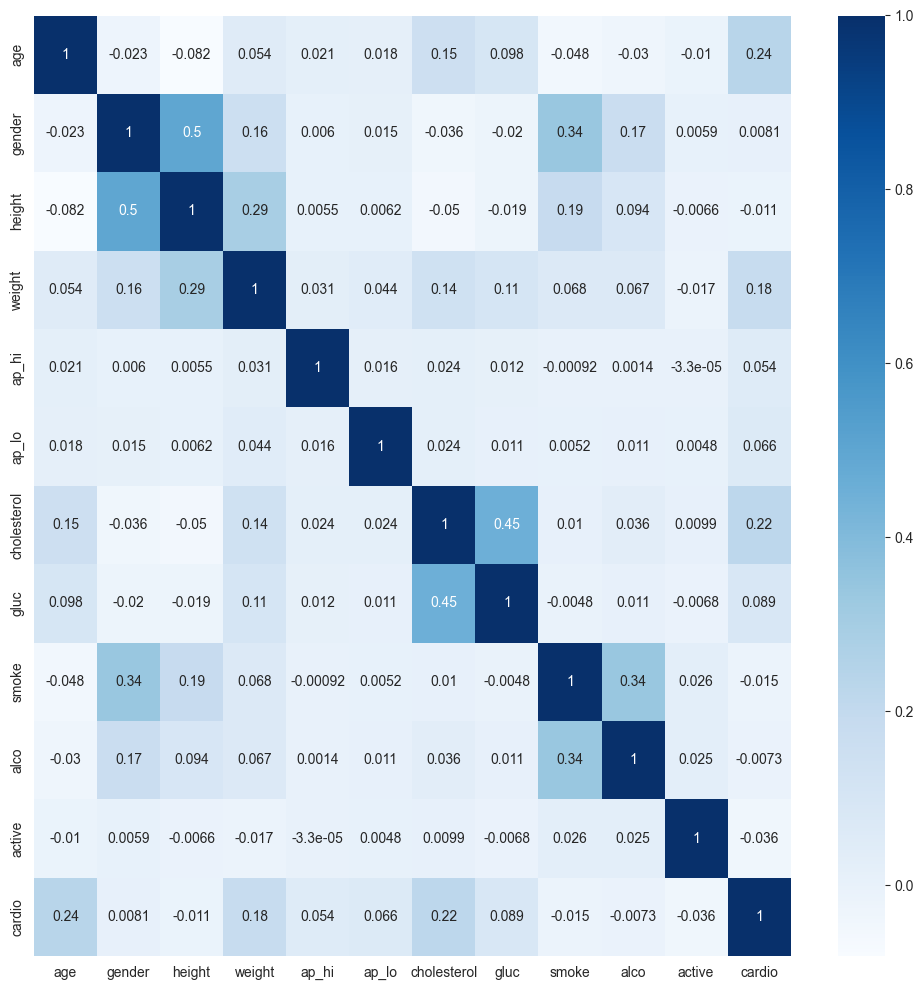

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(hear_corr, annot=True, cmap='Blues')
plt.tight_layout()

In [11]:
age_cardio = pd.DataFrame({
    'The Cardiac disease by average' : heart.groupby('age')['cardio'].mean(numeric_only=True),
    'Age' : sorted(heart['age'].unique())
})
px.bar(age_cardio, 'Age', 'The Cardiac disease by average', color='Age',
       title='The risk of Cardiac disease by increasing Age')

In [12]:
bins = [0, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, float('inf')]

# Group weight into ranges
weight_ranges = pd.cut(heart['weight'], bins=bins)

# Convert weight ranges to strings
weight_ranges_str = weight_ranges.astype(str)

# Create a new DataFrame with weight ranges and corresponding incidence of cardiovascular disease
wt_cardio = heart.groupby(weight_ranges_str)['cardio'].mean().reset_index()

# Manually sort the weight ranges in ascending order
sorted_weight_ranges = sorted(weight_ranges_str.unique(), key=lambda x: float(x.split(',')[0].split('(')[1]))
wt_cardio['weight'] = pd.Categorical(wt_cardio['weight'], categories=sorted_weight_ranges, ordered=True)

# Plot
fig = px.bar(wt_cardio, x='weight', y='cardio', title='Relationship between Weight and Cardiovascular Disease',
             labels={'weight': 'Weight Range (kg)', 'cardio': 'Average Incidence of Cardiovascular Disease'})
fig.show()


In [13]:
age_chol = pd.DataFrame({
    'The Cardiac disease by average' : heart.groupby('cholesterol')['cardio'].mean(numeric_only=True),
    'The amount of Cholesterol' : ['Normal', 'Above Normal', 'Well Above Normal']
})
px.bar(age_chol, 'The amount of Cholesterol', 'The Cardiac disease by average',
       color='The amount of Cholesterol', title='The risk of Cardiac disease by increasing Cholesterol')

In [14]:
age_chol = pd.DataFrame({
    'The Cardiac disease by average' : heart.groupby('gluc')['cardio'].mean(numeric_only=True),
    'The amount of Blood Glucose' : ['Normal', 'Above Normal', 'Well Above Normal']
})
px.bar(age_chol, 'The amount of Blood Glucose', 'The Cardiac disease by average',
       color='The amount of Blood Glucose', title='The risk of Cardiac disease by increasing Blood Glucose')

In [15]:
import pandas as pd
import plotly.express as px

# Calculate the average occurrence of cardiovascular diseases for each factor
smoke_avg = heart.groupby('smoke')['cardio'].mean().reset_index()
alco_avg = heart.groupby('alco')['cardio'].mean().reset_index()
active_avg = heart.groupby('active')['cardio'].mean().reset_index()

# Rename columns for clarity
smoke_avg.rename(columns={'cardio': 'Cardiovascular Disease', 'smoke': 'Factor'}, inplace=True)
alco_avg.rename(columns={'cardio': 'Cardiovascular Disease', 'alco': 'Factor'}, inplace=True)
active_avg.rename(columns={'cardio': 'Cardiovascular Disease', 'active': 'Factor'}, inplace=True)

# Convert binary indicators to more descriptive labels
smoke_avg['Factor'] = smoke_avg['Factor'].map({0: 'Non-Smoker', 1: 'Smoker'})
alco_avg['Factor'] = alco_avg['Factor'].map({0: 'No Alcohol', 1: 'Alcohol'})
active_avg['Factor'] = active_avg['Factor'].map({0: 'No Exercise', 1: 'Exercise'})

# Concatenate the DataFrames for plotting
combined = pd.concat([smoke_avg, alco_avg, active_avg], ignore_index=True)

# Plot using Plotly Express
fig = px.bar(combined, x='Factor', y='Cardiovascular Disease', color='Factor', facet_col='Factor', facet_col_wrap=3,
             category_orders={"Factor": ["Non-Smoker", "Smoker", "No Alcohol", "Alcohol", "No Exercise", "Exercise"]},
             labels={'Factor': ''},
             barmode='group',
             color_discrete_map={
                 "Non-Smoker": "red", 
                 "Smoker": "orange", 
                 "No Alcohol": "blue", 
                 "Alcohol": "green", 
                 "No Exercise": "purple", 
                 "Exercise": "pink"
             },
             title='Relationship Between Lifestyle Factors and Cardiovascular Disease')
fig.update_layout(margin=dict(t=50))
fig.show()


In [16]:
X = heart.drop('cardio', axis=1)
y = heart['cardio']

In [17]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([35021, 34979], dtype=int64))

##  Data Transformation

In [18]:
y = pd.get_dummies(y) 
y.head()

,0,1
0,True,False
1,False,True
2,False,True
3,False,True
4,True,False


In [19]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [20]:
X

array([[-0.41980002,  1.36405487,  0.44345206, ..., -0.31087913,
        -0.23838436,  0.49416711],
       [ 0.31910983, -0.73310834, -1.01816804, ..., -0.31087913,
        -0.23838436,  0.49416711],
       [-0.27201805, -0.73310834,  0.07804703, ..., -0.31087913,
        -0.23838436, -2.02360695],
       ...,
       [-0.12423608,  1.36405487,  2.27047718, ..., -0.31087913,
         4.19490608, -2.02360695],
       [ 1.20580165, -0.73310834, -0.16555632, ..., -0.31087913,
        -0.23838436, -2.02360695],
       [ 0.4668918 , -0.73310834,  0.68705541, ..., -0.31087913,
        -0.23838436,  0.49416711]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
neural_network = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Dense(units=X_train.shape[1], activation='relu', input_shape=(11,)),
    # Hidden Layer
    tf.keras.layers.Dense(units=3390, activation='relu'),
    tf.keras.layers.Dropout(rate=0.6134244952254351),
    tf.keras.layers.Dense(units=1921, activation='relu'),
    tf.keras.layers.Dropout(0.8995971525795465),
    tf.keras.layers.Dense(units=696, activation='relu'),
    tf.keras.layers.Dropout(0.37728953141458194),
    tf.keras.layers.Dense(units=3203, activation='relu'),
    tf.keras.layers.Dropout(0.4140447715184241),
    tf.keras.layers.Dense(units=1191, activation='relu'),
    tf.keras.layers.Dropout(0.777425398521235),
    # Output Layer
    tf.keras.layers.Dense(units=2, activation='softmax')
])

neural_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=tf.keras.metrics.CategoricalAccuracy())
print(neural_network.summary())

BATCH_SIZE = 256
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
MC = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True)
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=.2, patience=2)
STEPS_PER_EPOCHS = round(X_train.shape[0] / BATCH_SIZE)
history = neural_network.fit(
    X_train,
    y_train,
    steps_per_epoch=STEPS_PER_EPOCHS,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    callbacks=[ES, MC, RLR]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 3390)              40680     
                                                                 
 dropout (Dropout)           (None, 3390)              0         
                                                                 
 dense_2 (Dense)             (None, 1921)              6514111   
                                                                 
 dropout_1 (Dropout)         (None, 1921)              0         
                                                                 
 dense_3 (Dense)             (None, 696)               1337712   
                                                                 
 dropout_2 (Dropout)         (None, 696)               0

# 4. Data Evaluation

## Data Visualization

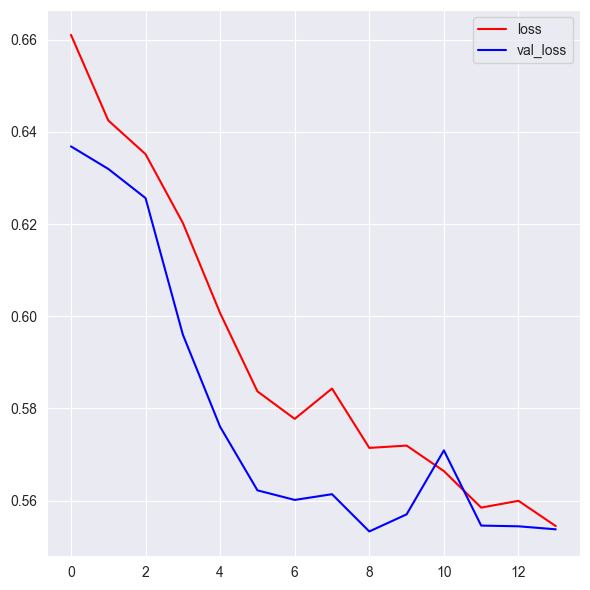

In [32]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], color='red', label='loss');
plt.plot(history.history['val_loss'], color='blue', label='val_loss');
plt.legend();
plt.tight_layout();

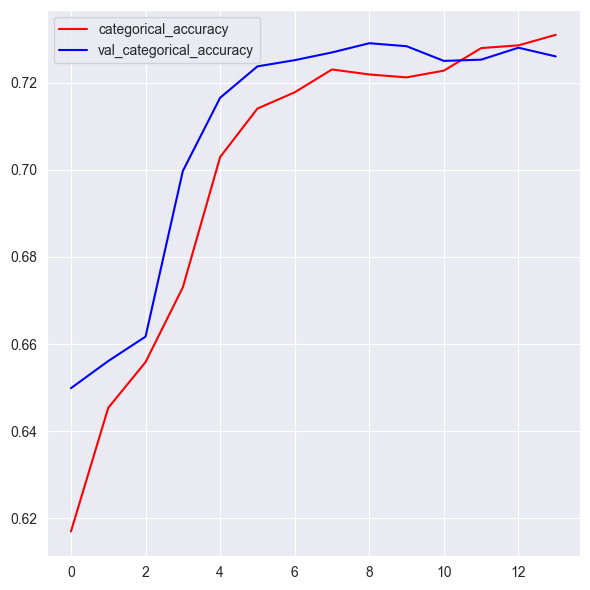

In [31]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['categorical_accuracy'], color='red', label='categorical_accuracy');
plt.plot(history.history['val_categorical_accuracy'], color='blue', label='val_categorical_accuracy');
plt.legend();
plt.tight_layout();

## Model Evaluation

In [33]:
y_preds = neural_network.predict(X_test)

547/547 [==============================] - 11s 20ms/step


In [34]:
y_preds

array([[0.7944763 , 0.20552373],
       [0.7141407 , 0.28585932],
       [0.6244449 , 0.37555513],
       ...,
       [0.81393045, 0.18606962],
       [0.3766176 , 0.6233824 ],
       [0.2650985 , 0.7349015 ]], dtype=float32)

In [35]:
pred_vals = []
for y_pred in y_preds:
    pred_vals.append(np.argmax(y_pred))
    
true_vals = []
for val in y_test.values:
    true_vals.append(np.argmax(val))

In [36]:
print(classification_report(true_vals, pred_vals))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      8820
           1       0.70      0.78      0.74      8680

    accuracy                           0.73     17500
   macro avg       0.73      0.73      0.73     17500
weighted avg       0.73      0.73      0.73     17500



In [37]:
print(confusion_matrix(true_vals, pred_vals))

[[5975 2845]
 [1950 6730]]


In [46]:
def calculate_bmi(weight_kg, height_cm):
    height_m = height_cm / 100  # Convert height from cm to meters
    bmi = weight_kg / (height_m ** 2)  # BMI formula: weight (kg) / height^2 (m^2)
    return bmi

def suggest_weight_reduction(current_bmi):
    ideal_bmi = 22  # Ideal BMI for good health
    height_m=height_cm/100
    target_weight = ideal_bmi * (height_m ** 2)  # Target weight for ideal BMI
    weight_reduction = max(0, weight_kg - target_weight)  # Calculate weight reduction needed

    return weight_reduction

user_input = {
    'age': 35,  #in years
    'gender': 1,  # Male (assuming 1 for male and 2 for female, adjust according to your dataset)
    'height': 188,  # Height in cm
    'weight': 100,  # Weight in kg
    'ap_hi': 110,  # Normal	systolic: less than 120 mm Hg, At Risk (prehypertension)systolic: 120–139 mm Hg
    #High Blood Pressure (hypertension)	systolic: 140 mm Hg 

    'ap_lo': 60,  #  Normal diastolic: less than 80 mm Hg,At Risk (prehypertension)diastolic: 80–89 mm Hg
    #High Blood Pressure (hypertension)diastolic: 90 mm Hg or higher

    'cholesterol':3,  # 0-Normal,1-above normal,2-much above normal
    'gluc': 3,  # 0-Normal,1-above normal,2-much above normal
    'smoke': 1,  # 0-Non-smoker, 1-smoker 
    'alco': 1,  # 0-Non-alcoholic, 1-alcoholic
    'active': 0  # 0-inactive,1-Active
}

# Convert user input into DataFrame
user_input_df = pd.DataFrame([user_input])

user_input_scaled = ss.transform(user_input_df)  # Use your actual preprocessing steps here

# Use the trained neural network to make a prediction
prediction = neural_network.predict(user_input_scaled)
predicted_class = np.argmax(prediction, axis=1) 

# Interpret the prediction
if predicted_class[0] == 0:
    print("The model predicts no cardiovascular disease.")
else:
    print("The model predicts cardiovascular disease.")

print("\n---------Few Health Tips----------\n")
weight_kg = user_input_df['weight'].values[0]
height_cm = user_input_df['height'].values[0]
bmi = calculate_bmi(weight_kg, height_cm)

# Suggest weight reduction if BMI is above ideal range
if bmi > 22:
    weight_reduction_needed = suggest_weight_reduction(bmi)
    print(f"Your BMI is {bmi:.2f}. To achieve an ideal BMI of 22, you need to reduce your weight by {weight_reduction_needed:.2f} kg.")
else:
    print(f"Your BMI is : {bmi:.2f}, which is healthy......")

if user_input["smoke"] == 1:
    print("Smoking is harmful to your health. Consider quitting smoking.")
if user_input["alco"] == 1:
    print("Limit alcohol consumption for better health.")
if user_input["active"] == 0:
    print("Regular physical activity is essential for maintaining good health.")

1/1 [==============================] - 0s 44ms/step
The model predicts cardiovascular disease.

---------Few Health Tips----------

Your BMI is 28.29. To achieve an ideal BMI of 22, you need to reduce your weight by 22.24 kg.
Smoking is harmful to your health. Consider quitting smoking.
Limit alcohol consumption for better health.
Regular physical activity is essential for maintaining good health.
